# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

### Homework 1 is due February 6th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [3]:
train_df = pd.read_csv('data/calendar_train.csv', parse_dates=['date']).dropna()
test_df = pd.read_csv('data/calendar_test.csv', parse_dates=['date']).dropna()


### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

In [4]:
month_df = train_df.groupby(train_df.date.dt.month).mean()
day_df = train_df.groupby(train_df.date.dt.weekday).mean()
month_df.head()

,listing_id,price
date,,
1,1.233595e+07,185.940598
2,1.213275e+07,190.617247
3,1.200374e+07,220.600371
4,1.143202e+07,278.442433
5,1.129967e+07,288.174429


[Text(0, 0.5, 'Average AirBnB Price'),
 Text(0.5, 0, 'Day'),
 Text(0.5, 1.0, 'Average Boston AirBnB Price by Day of Week')]

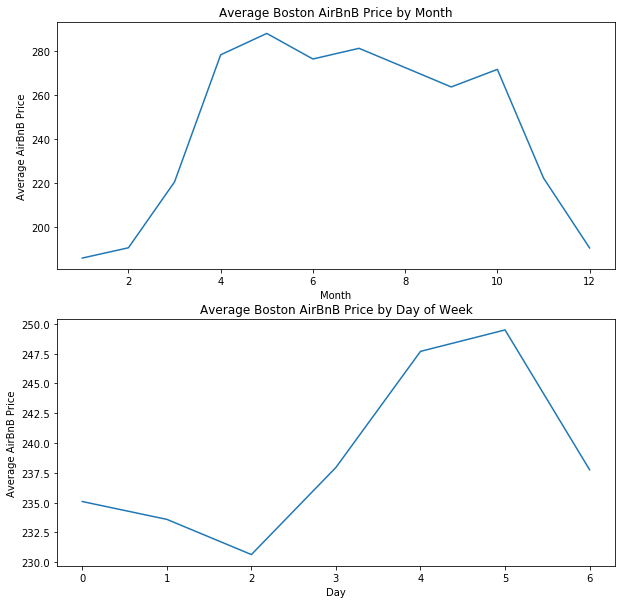

In [5]:
fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(month_df.index, month_df['price'])
ax[0].set(xlabel='Month', ylabel='Average AirBnB Price',
       title='Average Boston AirBnB Price by Month')

ax[1].plot(day_df.index, day_df['price'])
ax[1].set(xlabel='Day', ylabel='Average AirBnB Price',
       title='Average Boston AirBnB Price by Day of Week')

The trends displayed above make sense to me, as airBnb's are most expensive in the summer and cheapest in the winter, and most expensive on friday/saturdays and cheapest midweek.

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [6]:
min_date = min([train_df['date'].min(), test_df['date'].min()])
train_df['days_since'] = (train_df['date'] - min_date).dt.days
test_df['days_since'] = (test_df['date'] - min_date).dt.days


### 1. Polynomials

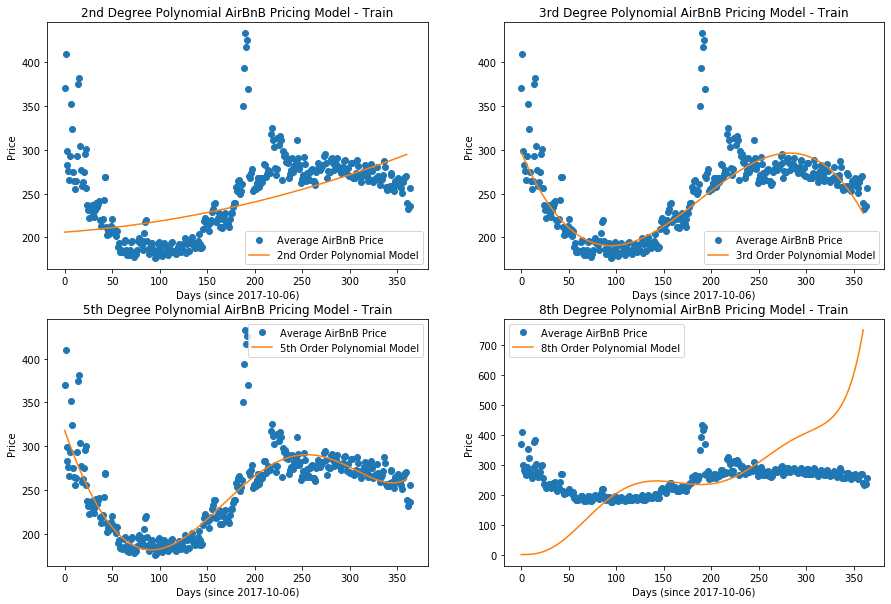

In [7]:

def fit_model(formula):
    return sm.ols(formula=formula, data=train_df).fit()


day_range = pd.DataFrame(np.linspace(0,360,361))
day_range.columns = ['days_since']


fig, ax = plt.subplots(2,2,figsize=(15,10))
day_df = train_df.groupby(train_df['days_since']).mean()
ax[0,0].plot(day_df.index, day_df['price'], 'o', label="Average AirBnB Price")

formula_2 = "price ~ np.vander(days_since, 3, increasing=True) - 1"
fit2_lm = fit_model(formula_2)
fit2_summary = fit2_lm.get_prediction(exog=day_range).summary_frame()
ax[0,0].plot(fit2_summary.index, fit2_summary['mean'], '-', label="2nd Order Polynomial Model")
ax[0,0].set(xlabel='Days (since 2017-10-06)', ylabel='Price',
       title='2nd Degree Polynomial AirBnB Pricing Model - Train')
ax[0,0].legend()

ax[0,1].plot(day_df.index, day_df['price'], 'o', label="Average AirBnB Price")
formula_3 = "price ~ np.vander(days_since, 4, increasing=True) - 1"
fit3_lm = fit_model(formula_3)
fit3_summary = fit3_lm.get_prediction(exog=day_range).summary_frame()
ax[0,1].plot(fit3_summary.index, fit3_summary['mean'], '-', label="3rd Order Polynomial Model")
ax[0,1].set(xlabel='Days (since 2017-10-06)', ylabel='Price',
       title='3rd Degree Polynomial AirBnB Pricing Model - Train')
ax[0,1].legend()

ax[1,0].plot(day_df.index, day_df['price'], 'o', label="Average AirBnB Price")
formula_5 = "price ~ np.vander(days_since, 6, increasing=True) - 1"
fit5_lm = fit_model(formula_5)
fit5_summary = fit5_lm.get_prediction(exog=day_range).summary_frame()
ax[1,0].plot(fit5_summary.index, fit5_summary['mean'], '-', label="5th Order Polynomial Model")
ax[1,0].set(xlabel='Days (since 2017-10-06)', ylabel='Price',
       title='5th Degree Polynomial AirBnB Pricing Model - Train')
ax[1,0].legend()

ax[1,1].plot(day_df.index, day_df['price'], 'o', label="Average AirBnB Price")
formula_8 = "price ~ np.vander(days_since, 9, increasing=True) - 1"
fit8_lm = fit_model(formula_8)
fit8_summary = fit8_lm.get_prediction(exog=day_range).summary_frame()
ax[1,1].plot(fit8_summary.index, fit8_summary['mean'], '-', label="8th Order Polynomial Model")
ax[1,1].set(xlabel='Days (since 2017-10-06)', ylabel='Price',
       title='8th Degree Polynomial AirBnB Pricing Model - Train')
ax[1,1].legend()


# ax.plot(day_range, fit2_lm.predict(day_range), 'o')

# poly_3 = PolynomialFeatures(3)
# poly_5 = PolynomialFeatures(5)
# poly_8 = PolynomialFeatures(8)




In [8]:
print('2nd Order Train R^2: ',r2_score(train_df.price, fit2_lm.get_prediction(exog=train_df).summary_frame()['mean']))
print('2nd Order Test R^2: ',r2_score(test_df.price, fit2_lm.get_prediction(exog=test_df).summary_frame()['mean']))

print('3rd Order Train R^2: ',r2_score(train_df.price, fit3_lm.get_prediction(exog=train_df).summary_frame()['mean']))
print('3rd Order Test R^2: ',r2_score(test_df.price, fit3_lm.get_prediction(exog=test_df).summary_frame()['mean']))

print('5th Order Train R^2: ',r2_score(train_df.price, fit5_lm.get_prediction(exog=train_df).summary_frame()['mean']))
print('5th Order Test R^2: ',r2_score(test_df.price, fit5_lm.get_prediction(exog=test_df).summary_frame()['mean']))

print('8th Order Train R^2: ',r2_score(train_df.price, fit8_lm.get_prediction(exog=train_df).summary_frame()['mean']))
print('8th Order Test R^2: ',r2_score(test_df.price, fit8_lm.get_prediction(exog=test_df).summary_frame()['mean']))

2nd Order Train R^2:  0.01848857368742829
2nd Order Test R^2:  0.01918039277021588
3rd Order Train R^2:  0.03893294505042644
3rd Order Test R^2:  0.03875184567497636
5th Order Train R^2:  0.042100254532704606
5th Order Test R^2:  0.04173806101773425
8th Order Train R^2:  -0.17019496979771298
8th Order Test R^2:  -0.15800914293661172


2nd Order Train R^2:  0.01848857368742829

2nd Order Test R^2:  0.01918039277021588

3rd Order Train R^2:  0.03893294505042644

3rd Order Test R^2:  0.03875184567497636

5th Order Train R^2:  0.042100254532704606

5th Order Test R^2:  0.04173806101773425

8th Order Train R^2:  -0.17019496979771298

8th Order Test R^2:  -0.15800914293661172

### 2. Degree 8 oddity
The oddity of the poor fit from the 8th order polynomial potentially a result of runge's phenomenon. Additionally, it may be a result of the fact that the difference between high order polynomial basis functions is pretty slim (x^7 and x^8 are close to being on top of each other). As such, small changes in the data can wildly affect the coeffecients on the polynomials. In order to improve this, we can change the bases to the Legendre polynomials, which are distinct enough that each coeffecient will remain relatively unchanged with little changes in the data. As such, imposing such poor basis functions is going to result in a bad fit.

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

Lam:  0  Test R^2:  0.04805265106798329
Lam:  0  Train R^2:  0.048147288922810394
Lam:  5  Test R^2:  0.04806283783624676
Lam:  5  Train R^2:  0.0481053770081048
Lam:  10  Test R^2:  0.04803861671095433
Lam:  10  Train R^2:  0.04807041797142675
Lam:  20  Test R^2:  0.047975597369652734
Lam:  20  Train R^2:  0.04800066661792668
Lam:  200  Test R^2:  0.04727101409786849
Lam:  200  Train R^2:  0.04734580767467478


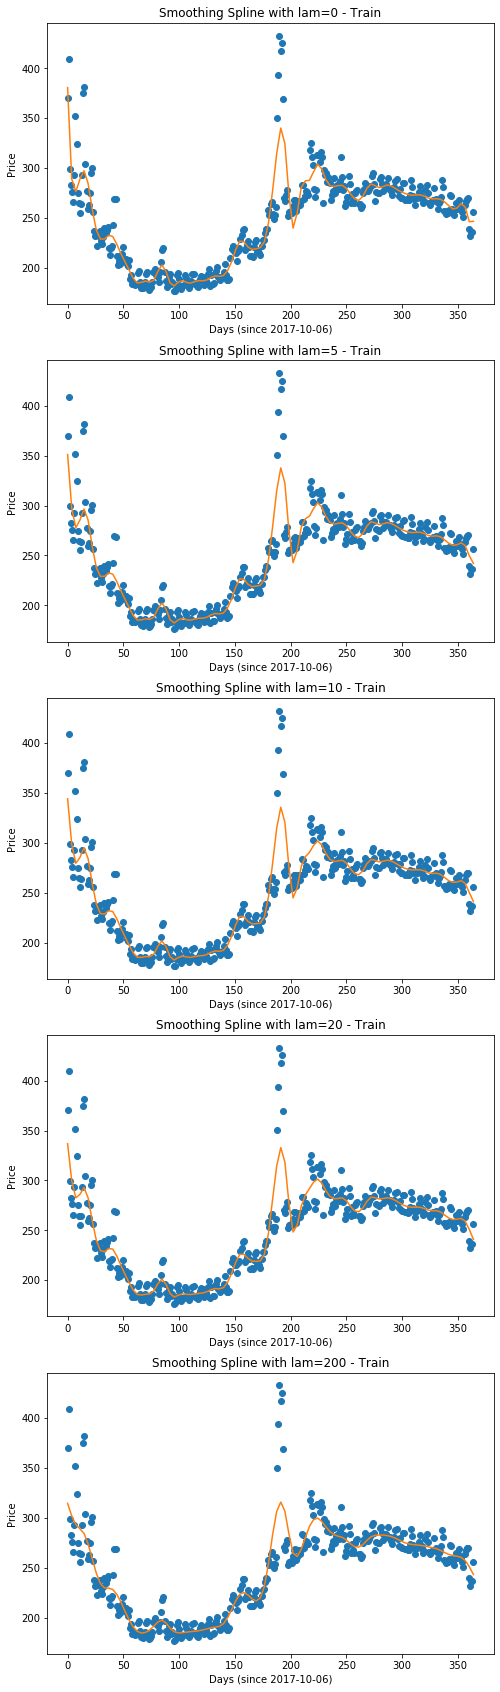

In [9]:
lams = [0, 5, 10, 20, 200]
fig, ax = plt.subplots(5,1,figsize=(8,30))
for i in range(len(lams)):
    gam = LinearGAM(lam=lams[i], n_splines=50). fit(train_df['days_since'],train_df['price'])
    XX = gam.generate_X_grid(term=0)
    ax[i].plot(day_df.index, day_df['price'], 'o', label="Average AirBnB Price")
    ax[i].plot(XX, gam.predict(XX));
    ax[i].set(xlabel='Days (since 2017-10-06)', ylabel='Price',
       title='Smoothing Spline with lam='+str(lams[i])+' - Train')
    print('Lam: ', lams[i], ' Test R^2: ', r2_score(test_df.price, gam.predict(test_df['days_since'])))
    print('Lam: ', lams[i], ' Train R^2: ', r2_score(train_df.price, gam.predict(train_df['days_since'])))
    




Degree:  10  Test R^2:  0.0433679754153824
Degree:  10  Train R^2:  0.04366904109733172
Degree:  50  Test R^2:  0.04806283783624676
Degree:  50  Train R^2:  0.0481053770081048
Degree:  100  Test R^2:  0.05126778935129006
Degree:  100  Train R^2:  0.051374917501948336
Degree:  200  Test R^2:  0.05258875203395019
Degree:  200  Train R^2:  0.053205900196872324


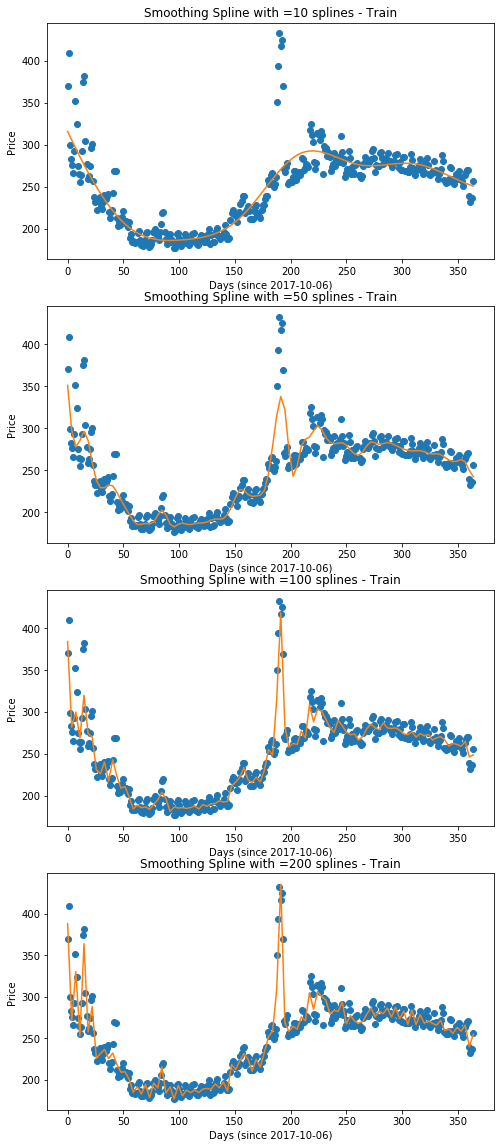

In [10]:
degrees = [10, 50, 100, 200]
fig, ax = plt.subplots(4,1,figsize=(8,20))
for i in range(len(degrees)):
    gam = LinearGAM(lam=5, n_splines=degrees[i]). fit(train_df['days_since'],train_df['price'])
    XX = gam.generate_X_grid(term=0)
    ax[i].plot(day_df.index, day_df['price'], 'o', label="Average AirBnB Price")
    ax[i].plot(XX, gam.predict(XX));
    ax[i].set(xlabel='Days (since 2017-10-06)', ylabel='Price',
       title='Smoothing Spline with ='+str(degrees[i])+' splines - Train')
    print('Degree: ', degrees[i], ' Test R^2: ', r2_score(test_df.price, gam.predict(test_df['days_since'])))
    print('Degree: ', degrees[i], ' Train R^2: ', r2_score(train_df.price, gam.predict(train_df['days_since'])))

### 4. Effects of parameters
Via cross-validation, I have determined that the best lambda value is 5 (out of [0, 5, 10, 20, 200]), though the discrepancy between 0 and 5 was rather small. The higher the number of splines, generally, the better our r2 value on the test set was. I'm a bit unsure how to feel about this; on one hand, this can lead to overfitting and higher number of takes a long time to fit the model. However, this dataset does display trends that are specific to certain days of the year or days of the week -- weekends and specific holidays are going to be higher than days where there was a snowstorm or something like that. In the end, I'm ok settling on 200 splines, which should capturance this nuance in the dataset.

My best params are lam=5, n_splines=200

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


Degree:  200  Test R^2:  0.05277052266012461
Degree:  200  Train R^2:  0.05330154545614296


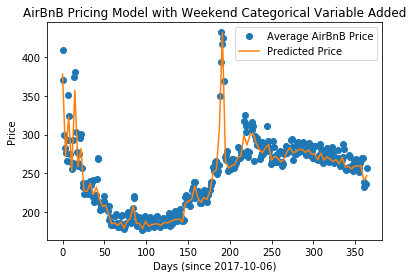

In [20]:
train_df['weekday'] = np.where((train_df.date.dt.weekday ==4) | (train_df.date.dt.weekday ==5), 1, 0)
test_df['weekday'] = np.where((test_df.date.dt.weekday ==4) | (test_df.date.dt.weekday ==5), 1, 0)
gam = LinearGAM(s(0) + f(1), lam=5, n_splines=200). fit(train_df[['days_since', 'weekday']],train_df['price'])
XX = gam.generate_X_grid(term=0)
fig, ax = plt.subplots()
ax.plot(day_df.index, day_df['price'], 'o', label="Average AirBnB Price")
ax.plot(XX[:,0], gam.predict(XX), label="Predicted Price");
ax.set(xlabel='Days (since 2017-10-06)', ylabel='Price',
       title='AirBnB Pricing Model with Weekend Categorical Variable Added')
ax.legend()
print('Degree: ', 200, ' Test R^2: ', r2_score(test_df.price, gam.predict(test_df[['days_since', 'weekday']])))
print('Degree: ', 200, ' Train R^2: ', r2_score(train_df.price, gam.predict(train_df[['days_since', 'weekday']])))

Interestingly, in this case, adding the weekend value actually decreases the performance of my model. This is, however, because I already have 200 splines, which are presumably already capturing the behavior around each weekend. If I reduce the number of splines down to 50, then my performance does increase.

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [12]:
day_df.sort_values('price',ascending=False).head(10)

,listing_id,price,days_since
days_since,,,
190,1.133490e+07,432.680761,190.0
192,1.132853e+07,425.289528,192.0
191,1.097488e+07,417.170404,191.0
1,1.258238e+07,409.298701,1.0
189,1.133951e+07,393.609047,189.0
15,1.271969e+07,381.526515,15.0
14,1.226345e+07,374.955932,14.0
0,1.322575e+07,370.173410,0.0
193,1.122437e+07,369.371060,193.0


The 3 most expensive days (April 14th, 16th, and 15th, 2018) are the days around the Boston Marathon, so it follows that prices are high because of people in town for the race. The 4th highest is Columbus day weekend. The other days probably correspond to notable travel weekends and events in the city of Boston.

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

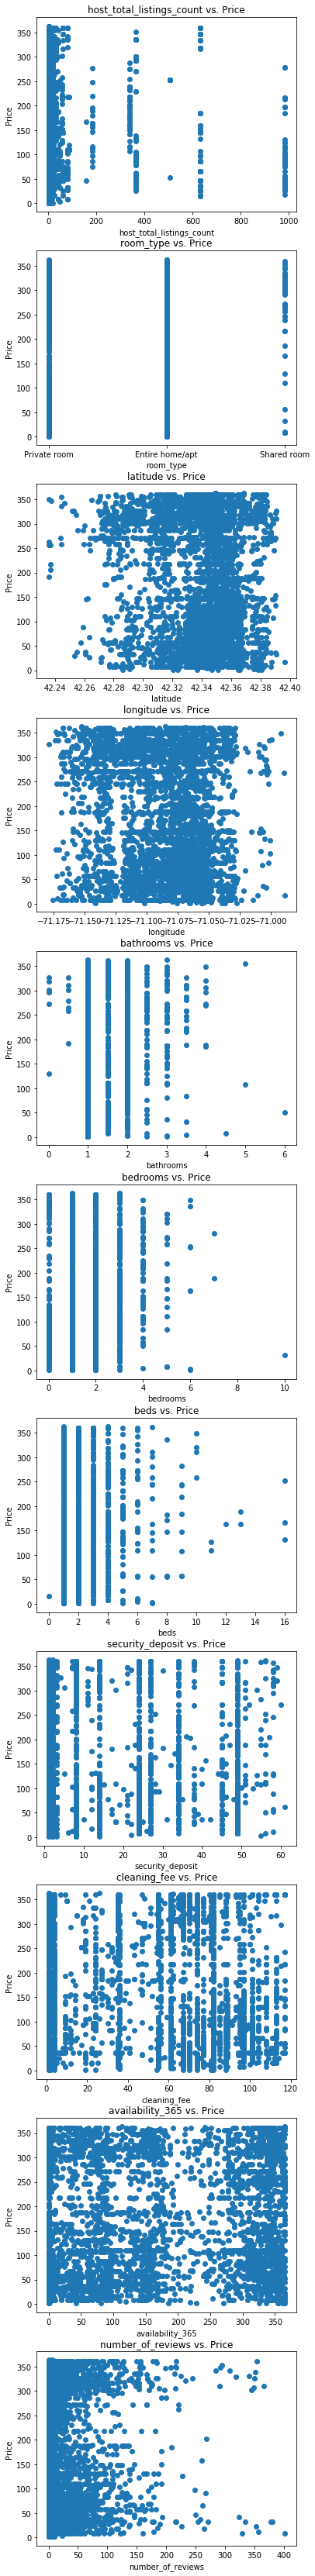

In [13]:
listings_train_df = pd.read_csv('data/listings_train.csv')
listings_test_df = pd.read_csv('data/listings_test.csv')
listings_test_df.head()
predictors = ['host_total_listings_count', 'room_type', 'latitude', 'longitude',
       'bathrooms', 'bedrooms', 'beds', 'security_deposit',
       'cleaning_fee', 'availability_365', 'number_of_reviews']
fig, ax = plt.subplots(len(predictors),figsize=(6,60))
for i in range(len(predictors)):
    ax[i].plot(listings_train_df[predictors[i]], listings_train_df.price, 'o')
    ax[i].set(xlabel=predictors[i], ylabel='Price',
       title=(str(predictors[i])+' vs. Price'))


No single variable seems to show a strong linear relationship, though some of the predictors are particularly non-linear. For instance, number of reviews seems to either indicate a high price or a low price, which host_total_listings seems to trend upwards to higher prices, before trending back downwards.

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [14]:
formula = ('price ~ np.vander(host_total_listings_count, 2, increasing=True) - 1'
          '+ room_type'
          '+ np.vander(latitude, 2, increasing=True) - 1'
          '+ np.vander(longitude, 2, increasing=True) - 1'
          '+ np.vander(bathrooms, 2, increasing=True) - 1'
          '+ np.vander(bedrooms, 2, increasing=True) - 1'
          '+ np.vander(beds, 2, increasing=True) - 1'
          '+ np.vander(security_deposit, 2, increasing=True) - 1'
          '+ np.vander(cleaning_fee, 2, increasing=True) - 1'
          '+ np.vander(availability_365, 2, increasing=True) - 1'
          '+ np.vander(number_of_reviews, 2, increasing=True) - 1')
lin = sm.ols(formula=formula,data=listings_train_df).fit()
print('Linear Train R^2: ',r2_score(listings_train_df.price, lin.get_prediction(exog=listings_train_df[predictors]).summary_frame()['mean']))
print('Linear Test R^2: ',r2_score(listings_test_df.price, lin.get_prediction(exog=listings_test_df[predictors]).summary_frame()['mean']))


Linear Train R^2:  0.24941504849625185
Linear Test R^2:  0.1847912723111904


In [15]:
formula = ('price ~ np.vander(host_total_listings_count, 4, increasing=True) - 1'
          '+ room_type'
          '+ np.vander(latitude, 4, increasing=True) - 1'
          '+ np.vander(longitude, 4, increasing=True) - 1'
          '+ np.vander(bathrooms, 4, increasing=True) - 1'
          '+ np.vander(bedrooms, 4, increasing=True) - 1'
          '+ np.vander(beds, 4, increasing=True) - 1'
          '+ np.vander(security_deposit, 4, increasing=True) - 1'
          '+ np.vander(cleaning_fee, 4, increasing=True) - 1'
          '+ np.vander(availability_365, 4, increasing=True) - 1'
          '+ np.vander(number_of_reviews, 4, increasing=True) - 1')
poly_3 = sm.ols(formula=formula,data=listings_train_df).fit()
print('3rd Order Poly Train R^2: ',r2_score(listings_train_df.price, poly_3.get_prediction(exog=listings_train_df[predictors]).summary_frame()['mean']))
print('3rd Order Poly Test R^2: ',r2_score(listings_test_df.price, poly_3.get_prediction(exog=listings_test_df[predictors]).summary_frame()['mean']))


3rd Order Poly Train R^2:  0.2706476978189254
3rd Order Poly Test R^2:  0.23783865395224735


### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


While I can't be certain without actually doing it and comparing the r2 values, it would make sense that some of these predictors don't have nth degree polynomial correlations to price, and thus, using a GAM would allow us to capture more nuanced relationships between each of the predictors.

In [16]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(listings_train_df['room_type'])
listings_train_df['room_type'] = le.transform(listings_train_df['room_type'])
listings_test_df['room_type'] = le.transform(listings_test_df['room_type'])

listings_test_df.head()





,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,3,1,42.280279,-71.135870,2.5,1,1,271,2,2,286,17
1,1,1,42.285603,-71.144647,1.0,1,1,290,1,1,0,3
2,1,1,42.274408,-71.125294,1.0,1,3,62,1,82,240,3
3,1,0,42.287974,-71.129771,2.0,2,2,55,27,74,115,5
4,1,1,42.276913,-71.128233,1.5,1,1,326,1,1,361,27


In [17]:
test_r2 = np.zeros((20,3))
train_r2 = np.zeros((20,3))
lams = [0, 5, 10, 20, 200]

for i in range(len(lams)):
    gam = LinearGAM(s(0)+f(1)+s(2)+s(3)+s(4)+s(5)+s(6)+s(7)+s(8)+s(9)+s(10),lam=lams[i], n_splines=50). fit(listings_train_df[predictors],listings_train_df['price'])
    XX = gam.generate_X_grid(term=0)
    print('Test - Lambda: ',lams[i],' R^2 = ',r2_score(listings_test_df.price, gam.predict(listings_test_df[predictors])))
    print('Train - Lambda: ',lams[i],' R^2 = ',r2_score(listings_train_df.price, gam.predict(listings_train_df[predictors])))

        


    


Test - Lambda:  0  R^2 =  -5925.708615108011
Train - Lambda:  0  R^2 =  0.3464789516571716
Test - Lambda:  5  R^2 =  0.24699569172766234
Train - Lambda:  5  R^2 =  0.31288914930611633
Test - Lambda:  10  R^2 =  0.2473305937690048
Train - Lambda:  10  R^2 =  0.30784476896707014
Test - Lambda:  20  R^2 =  0.24692604797790252
Train - Lambda:  20  R^2 =  0.3031371818912617
Test - Lambda:  200  R^2 =  0.23995967710915045
Train - Lambda:  200  R^2 =  0.2867673983763186


Hence, via CV, the optimal lambda is 10

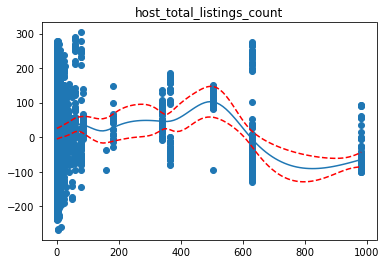

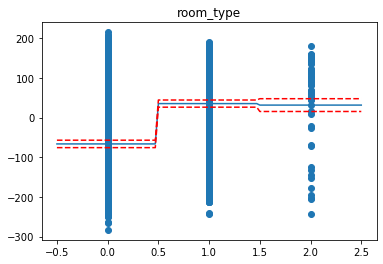

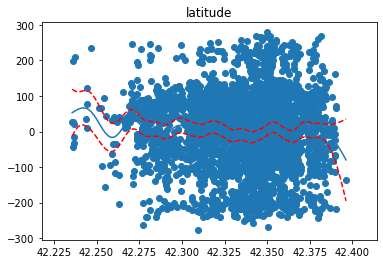

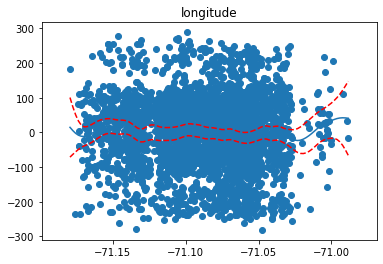

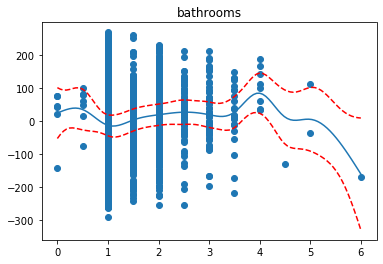

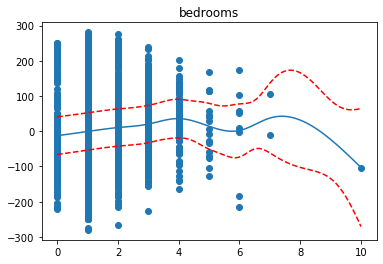

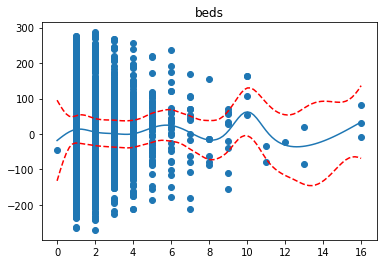

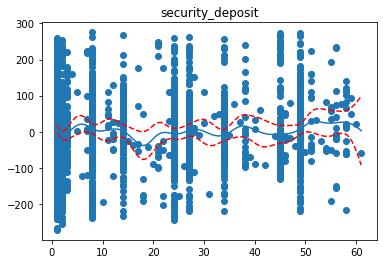

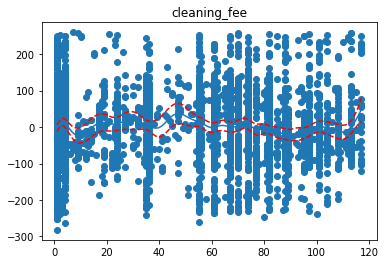

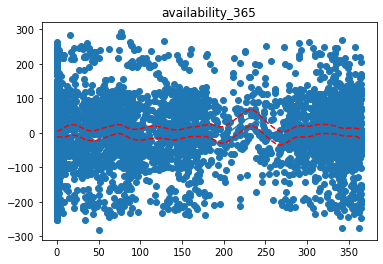

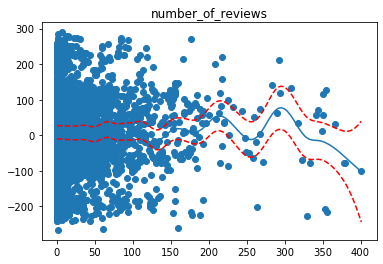

In [18]:
# Code via cs109b_smoothing.ipynb notebook
kyph_gam = LinearGAM(s(0)+f(1)+s(2)+s(3)+s(4)+s(5)+s(6)+s(7)+s(8)+s(9)+s(10),lam=10, n_splines=50). fit(listings_train_df[predictors],listings_train_df['price'])
res = kyph_gam.deviance_residuals(listings_train_df[predictors],listings_train_df['price'])
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = kyph_gam.generate_X_grid(term=i)
    pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = kyph_gam.partial_dependence(term=i, X=listings_train_df[predictors], width=0.95)
    plt.figure()
    plt.scatter(listings_train_df[predictors].iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(listings_train_df[predictors].columns.values[term.feature])
    plt.show()

In [19]:
kyph_gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    154.2015
Link Function:                     IdentityLink Log Likelihood:                                -44032.1382
Number of Samples:                         4370 AIC:                                            88374.6793
                                                AICc:                                           88386.1857
                                                GCV:                                            10121.4939
                                                Scale:                                           9480.7125
                                                Pseudo R-Squared:                                   0.3078
Feature Function                  Lam

/Users/Simon/.conda/envs/cs109b/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


From the plots above, there are clearly a number of nonlinear relationships between the predictors and price. For instance, as mentioned earlier, number of beadrooms will increase the price, to a point, before price actually decreases. A similar relationship exists between host's total listings and the price.

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

Per the P values of the predictors in my model, is seems as though the most significant predictors are host_total_listings_count and room_type, and availibility. Specifically, it seems that whole apartments are actually cheaper (this doesn't make a ton of sense to me, tbh), and places with hosts with the most listings (the slumlords of AirBnb) are cheapest. Moreover, it would make sense to avoid the most expensive times of year (April, October). As such, a frugal traveller should be willing to stay in a whole apartment (weirdly not private room) from a host who has a ton of listings, in the middle of the winter. Another significant factor is latitude, which makes sense, as some of boston's cheapest neighborhoods are in the far south (Dorchester) and north (Charlestown), while longitude has a lesser but still significant correlation. It seems a bit weird to treat these two variables as discrete, though, as I would assume that if we had a single variable to represent location (perhaps categorical by neighorhood), that would likely have one of the largest affects on price.  